In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import hashlib
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
# from plotly_resampler import FigureResampler, FigureWidgetResampler
from funcs import get_imbalance_price
from copulas.univariate import GaussianKDE, BetaUnivariate, GaussianUnivariate, GammaUnivariate, LogLaplace, StudentTUnivariate
from fetch_da_prices import load_and_process_boiler_data, get_day_ahead_prices
from  fetch_afrr_prices import get_afrr_data
from fetch_picasso_price import PicassoPrices
from scipy.stats import gaussian_kde

%load_ext autoreload
%autoreload 2

# With hourly separation

In [2]:
start = pd.Timestamp('20250304', tz='UTC')
end = pd.Timestamp('20250504', tz='UTC')

In [3]:
# P = PicassoPrices(start.strftime('%Y-%m-%d %H:%M:%S'), end.strftime('%Y-%m-%d %H:%M:%S'), 'DK1')
# P.prices_per_MTU()

In [4]:
capacity_up_hat = pd.read_parquet('C:/Users/labeli/Documents/Git/afrr-price-forecast-engine/data/results/afrr_price_forecast_UP.parquet')
da_prices_hat = load_and_process_boiler_data("C:/Users/labeli/OneDrive - Danmarks Tekniske Universitet/Dokumenter/Boiler case/Daily data")

da_prices = get_day_ahead_prices(start, end, price_area = "DK_1")
da_prices_hat = da_prices_hat.loc[start:end]
pic_up_prices = get_imbalance_price(start_date = start, end_date = end, price_area = "DK1")
capacity_up_hat.index = capacity_up_hat.index.tz_localize('UTC')

pic_up_prices.index = pic_up_prices.index.rename('time_utc')
pic_up_prices.index = pd.to_datetime(pic_up_prices.index, utc = True)
capacity_up_hat = capacity_up_hat.loc[start:end]

In [5]:
da_prices_df = da_prices_hat.join(da_prices, on = "time_utc")
da_prices_df["da_price"] = da_prices_df["da_price"].ffill()
da_prices_df["da_resid"] = da_prices_df["da_preds"] - da_prices_df["da_price"]

In [6]:
da_prices_df["da_resid"] = da_prices_df["da_resid"].diff(1)

In [7]:
data = pic_up_prices.join(capacity_up_hat, on = 'time_utc' )
data = pic_up_prices.join(capacity_up_hat, on = 'time_utc' )
data['pic_up_resid'] =  data['aFRRVWAUpEUR'] - data['SpotPriceEUR']

In [8]:
data = data.join(da_prices_df, on = 'time_utc', how = 'inner')

In [9]:
data = data.ffill()

In [10]:
# Ensure datetime index
data = data.sort_index()
data['date'] = data.index.date

# Keep only complete days (96 intervals)
valid_days = data['date'].value_counts()[data['date'].value_counts() == 96].index
data = data[data['date'].isin(valid_days)]

# Flatten each day into a single training row
residuals = ['cap_up_resid', 'da_resid', 'pic_up_resid']
flattened_rows = []

for date in valid_days:
    day_data = data[data['date'] == date]
    row = {}
    for col in residuals:
        for i, val in enumerate(day_data[col].values):
            row[f'{col}_{i}'] = val
    flattened_rows.append(row)

flattened_df = pd.DataFrame(flattened_rows)


In [11]:
from copulas.multivariate import GaussianMultivariate

copula = GaussianMultivariate()
copula.fit(flattened_df)


c:\Users\labeli\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\labeli\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\labeli\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\scipy\stats\_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
c:\Users\labeli\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\scipy\stats\_continuous_distns.py:5990: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
c:\Users\labeli\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid val

In [ ]:
from copulas.multivariate import GaussianMultivariate
import numpy as np
dist = GaussianMultivariate(distribution={"cap_up_resid": GaussianKDE, 
                                         "pic_up_resid": GaussianKDE, 
                                         "da_resid": GaussianKDE})
dist.fit(data[["cap_up_resid", "pic_up_resid", "da_resid"]])
samples = dist.sample(10000)

In [ ]:
import itertools
import pandas as pd

# === SETUP ===
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

def sample_quantile(samples, dist, target_quantile):
    cdf_values = samples.apply(dist.cumulative_distribution, axis=1)
    idx_closest = (cdf_values - target_quantile).abs().idxmin()
    return samples.loc[idx_closest]

# === 1. SPLIT DATA ===
data = data.sort_index()
last_day = data.index[-100].date()
train_data = data[data.index.date < last_day]
target_data = data[data.index.date == last_day]

# === 2. PRECOMPUTE CAPACITY SAMPLES ===
cap_samples = {
    q: sample_quantile(samples, dist, q)
    for q in quantiles
}

# === 3. SCENARIO GENERATION ===
start_day = last_day
end_day = start_day + pd.Timedelta(days=1)
down_cap = get_afrr_data(start = last_day, end = end_day, price_area = "DK_1")['aFRR_DownCapPriceEUR'].rename('opt_afrr_down_cap_price')
std_cap_down = down_cap.std()

In [ ]:
PICdata = PicassoPrices(start_date = last_day.strftime('%Y-%m-%d %H:%M:%S'), end_date = last_day.strftime('%Y-%m-%d %H:%M:%S'), price_area = "DK1")
pic_down = pd.Series(PICdata.prices_per_MTU()['aFRR_DownActivatedPrice_AvgMTU_EUR'])
std_pic_down = pic_down.std()
pic_down = pic_down.rename('pic_down_price')

In [ ]:
scenarios = {}
scenario_counter = 0  # initialize the counter

for cap_q, cap_sample in cap_samples.items():
    capq_str = 'cap'+str(int(cap_q*100))
    cap_resid = cap_sample['cap_up_resid']
    cap_price_series = target_data['opt_afrr_up_cap_price'] + cap_resid

    cap_down = down_cap + np.random.normal(0, std_cap_down, len(down_cap))
    cap_down = cap_down.clip(lower=0)

    for da_q in quantiles:
        daq_str = 'da'+str(int(da_q*100))
        da_resid_series = pd.Series(index=target_data.index, dtype=float)
        for t in target_data.index:
            resids = train_data.loc[train_data['opt_afrr_up_cap_price'] >= cap_price_series.loc[t], 'da_resid']
            da_resid_series.loc[t] = resids.loc[t.time()].quantile(da_q)
        da_price_series = target_data['da_preds'] + da_resid_series

        for pic_up_q in quantiles:
            picq_str = 'pic'+str(int(pic_up_q*100))
            pic_up_resid_series = pd.Series(index=target_data.index, dtype=float)
            for t in target_data.index:
                resids = train_data.loc[train_data['da_preds'] >= da_price_series.loc[t], 'pic_up_resid']
                pic_up_resid_series.loc[t] = resids.loc[t.time()].quantile(pic_up_q)
            pic_up_price_series = target_data['da_preds'] + pic_up_resid_series

            pic_down = pic_down + np.random.normal(0, std_pic_down, len(pic_down))
            pic_down = pic_down.replace(np.nan, -15000)

            # Name and store scenario
            scenario_name = f"sc{scenario_counter:03d}_{capq_str}_{daq_str}_{picq_str}"
            scenario_counter += 1

            scenarios[scenario_name] = {
                'cap_up': cap_price_series,
                'cap_down': pd.Series(cap_down, index = cap_price_series.index).ffill(),
                'da': da_price_series,
                'pic_up': pic_up_price_series,
                'pic_down': pic_down
            }

# scenarios

In [ ]:
def generate_history_groups(scenario_dict, stages):
    """
    Groups scenarios by identical combined time series over specified stages.

    Args:
        scenario_dict (dict): {'s_xxx': {'cap_up': pd.Series, 'da': pd.Series, ...}, ...}
        stages (list): e.g., ['cap_up', 'cap_down'], keys to combine for grouping
    
    Returns:
        dict: {hash_value: [scenario1, scenario2, ...], ...}
    """
    history_groups = {}
    for scenario, market_data in scenario_dict.items():
        combined_series_list = []
        for stage in stages:
            if stage not in market_data:
                raise KeyError(f"Stage '{stage}' not found in scenario '{scenario}'")
            combined_series_list.append(market_data[stage])

        combined_series = pd.concat(combined_series_list)
        flat_array = combined_series.values.astype(np.float64)
        hash_val = hashlib.md5(flat_array.tobytes()).hexdigest()

        if hash_val not in history_groups:
            history_groups[hash_val] = []
        history_groups[hash_val].append(scenario)
    return history_groups

def build_history_groups(hash_to_scenarios):
    """
    Assigns readable group names (h_0, h_1, ...) to scenario groups.
    
    Args:
        hash_to_scenarios (dict): {hash_value: [scenario1, scenario2, ...], ...}
    
    Returns:
        dict: {'h_0': [scenario1, scenario2, ...], 'h_1': [...], ...}
    """
    return {
        f"h_{i}": scenarios
        for i, scenarios in enumerate(hash_to_scenarios.values())
    }

# ✅ Example usage:
cap_groups = build_history_groups(generate_history_groups(scenarios, ['cap_up', 'cap_down']))
cap_da_groups = build_history_groups(generate_history_groups(scenarios, ['cap_up', 'cap_down', 'da']))
full_groups = build_history_groups(generate_history_groups(scenarios, ['cap_up', 'cap_down', 'da', 'pic_up', 'pic_down']))

In [ ]:
def scenarios_to_prices(scenarios, market):
    """
    Convert scenario dictionary to a DataFrame of prices for a specific market.
    
    Args:
        scenarios (dict): {'s_xxx': {'cap_up': pd.Series, 'da': pd.Series, ...}, ...}
        market (str): Market key to extract prices from scenarios ('cap_up', 'da', etc.)
    
    Returns:
        pd.DataFrame: DataFrame with scenario names as index and market prices as columns
    """
    return pd.DataFrame({
        scenario: data[market]
        for scenario, data in scenarios.items()
    })

In [ ]:
first_day = data.index[0].date()
cap_real = get_afrr_data(start=first_day, end=last_day, price_area="DK_1")
cap_real_up = pd.DataFrame(cap_real['aFRR_UpCapPriceEUR'])

cap_real_up['date'] = cap_real_up.index.date

# Filter to only complete days (24 hours)
counts = cap_real_up['date'].value_counts()
valid_days = counts[counts == 24].index.sort_values()

# Create the array: each row is 24 hourly values for a day
daily_arrays = []
for day in valid_days:
    day_vals = cap_real_up.loc[cap_real_up['date'] == day, 'aFRR_UpCapPriceEUR'].values
    daily_arrays.append(day_vals)

cap_real_up_24h_array = np.vstack(daily_arrays)  # shape: (num_days, 24)
# cap_real_up_24h_array[i] is the 24 hourly values for day i

cap_real_up_24h_array

array([[ 1.34,  1.34,  1.34, ...,  2.51,  1.34,  9.28],
       [ 9.28,  9.28,  9.28, ..., 40.12, 40.12, 16.49],
       [13.41, 16.49, 16.49, ..., 53.97, 47.48, 44.32],
       ...,
       [47.74, 46.06, 48.62, ..., 46.34, 40.86, 37.59],
       [35.38, 35.46, 50.66, ..., 65.98, 41.82, 62.2 ],
       [58.8 , 56.56, 70.96, ..., 64.47, 44.21, 39.12]])

Threshold Definition for euclidean distance method

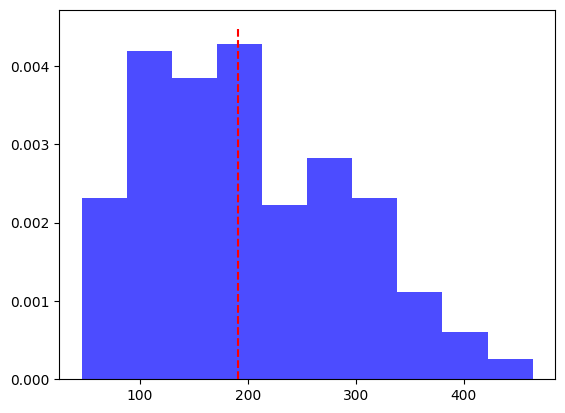

In [ ]:
from sklearn.metrics import euclidean_distances

dists_all = []

for q in quantiles: 
    q_str = 'cap'+str(int(q*100))
    for key in scenarios.keys():
        if q_str+'_da10_pic10' in key:
            sc_series = scenarios[key]['cap_up']
            sc = sc_series.drop_duplicates().values.reshape(1,-1)
            dists = euclidean_distances(sc, cap_real_up_24h_array)[0]
            dists_all = dists_all + list(dists)

# threshold = np.quantile(dists_all, 0.5)
threshold_cap = np.percentile(dists_all, 50)

plt.hist(dists_all, bins=10, density=True, alpha=0.7, color='blue')
plt.vlines(x=threshold_cap, ymin=0, ymax=plt.ylim()[1], color='red', linestyle='--', label='90th Percentile')
plt.show()

Goal is to define a function that takes the scenario key and then get the probability of that scenario

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 6))

rank_list = []
rank_dict = {}

for hist in cap_groups.keys():
    sc = cap_groups[hist][0]
    q_cap = sc.split('_')[1]
    cap_series = scenarios[sc]['cap_up']
    cap_list = cap_series.drop_duplicates().values.reshape(1,-1)

    # ax.plot(cap_series, label=f'{hist} (q={q_cap})', alpha=0.5)

    dists = euclidean_distances(cap_list, cap_real_up_24h_array)[0]
    rank = (dists < threshold_cap).sum()
    rank_list.append(rank)
    rank_dict[q_cap] = rank

rank_sum = sum(rank_list)
prob_cap = {k: v / rank_sum for k, v in rank_dict.items()}
print(prob_cap)
# fig.legend()
# plt.show()


{'cap10': 0.38571428571428573, 'cap25': 0.29285714285714287, 'cap50': 0.2642857142857143, 'cap75': 0.05, 'cap90': 0.007142857142857143}


In [ ]:

from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt

# Step 1: Build real 24-hour day-ahead price array
da_real = get_day_ahead_prices(start=first_day, end=last_day, price_area="DK_1")  # Adjust this function to match your data

da_real['date'] = da_real.index.date
counts_da = da_real['date'].value_counts()
valid_days_da = counts_da[counts_da == 24].index.sort_values()

daily_da_arrays = []
for day in valid_days_da:
    vals = da_real.loc[da_real['date'] == day, 'da_price'].values
    daily_da_arrays.append(vals)

da_real_24h_array = np.vstack(daily_da_arrays)

# Step 2: Calculate distances for each da-scenario
dists_all_da = []

for q in quantiles: 
    da_str = 'da'+str(int(q*100))
    for key in scenarios.keys():
        if 'cap50_' + da_str + '_pic10' in key:
            da_series = scenarios[key]['da']
            da_vec = da_series.drop_duplicates().values.reshape(1, -1)
            dists = euclidean_distances(da_vec, da_real_24h_array)[0]
            dists_all_da += list(dists)

# Step 3: Set percentile threshold (e.g. 50th)
threshold_da = np.percentile(dists_all_da, 50)

# Step 4: Plot distance distribution
plt.hist(dists_all_da, bins=10, density=True, alpha=0.7, color='green')
plt.vlines(x=threshold_da, ymin=0, ymax=plt.ylim()[1], color='red', linestyle='--', label='50th Percentile')
plt.title("Euclidean distances to historical day-ahead profiles")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.legend()
plt.show()

# Step 5: Rank each DA scenario group
rank_list_da = []
rank_dict_da = {}

for hist in cap_da_groups.keys():  # Change to your da groups if needed
    sc = cap_da_groups[hist][0]
    q_da = sc.split('_')[2]
    da_series = scenarios[sc]['da']
    da_vec = da_series.drop_duplicates().values.reshape(1, -1)

    dists = euclidean_distances(da_vec, da_real_24h_array)[0]
    rank = (dists < threshold_da).sum()
    rank_list_da.append(rank)
    rank_dict_da[q_da] = rank

# Normalize to probabilities
rank_sum_da = sum(rank_list_da)
prob_da = {k: v / rank_sum_da for k, v in rank_dict_da.items()}
print(prob_da)


ValueError: Input contains NaN.

In [ ]:
for key in scenarios.keys():
    n_sc = key.split('_')[0][-3:]
    q_cap = int(key.split('_')[1][-2:])/100
    q_da = int(key.split('_')[2][-2:])/100
    q_pic = int(key.split('_')[3][-2:])/100



In [ ]:

sample_day = sample_day.reshape(1, -1)
cap_real_up_24h_array = cap_real_up_24h_array.reshape(cap_real_up_24h_array.shape[0], -1)
dists = euclidean_distances(sample_day, cap_real_up_24h_array)[0]
rank = (dists < threshold).sum()

percentile = 1 - rank / len(dists)
percentile


In [ ]:
plt.hist(dists, bins=10, density=True, alpha=0.5, label='Euclidean Distances')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sample_day.flatten())
plt.plot(cap_real_up_24h_array[8])
plt.legend()
plt.title("Scenario vs. Real Sample")

In [ ]:
records = []
for scen_name, market_data in scenarios.items():
    for market, series in market_data.items():
        df = series.reset_index()
        df.columns = ['timestamp', 'price']
        df['scenario'] = scen_name
        df['market'] = market
        records.append(df)

scenario_df = pd.concat(records, ignore_index=True)
scenario_df

In [ ]:
# Invert the mapping to {scenario_name: group_id}
cap_scenario_to_group = {
    scenario: group_id
    for group_id, scenarios in cap_groups.items()
    for scenario in scenarios
}

cap_da_scenario_to_group = {
    scenario: group_id
    for group_id, scenarios in cap_da_groups.items()
    for scenario in scenarios
}

scenario_df['cap_hist'] = scenario_df['scenario'].map(cap_scenario_to_group)
scenario_df['cap_da_hist'] = scenario_df['scenario'].map(cap_da_scenario_to_group)

# scenario_df.to_csv('../data/scenarios_final3.csv', index=False)
scenario_df

In [ ]:
cap_groups_id = list(cap_groups.keys())
cap_da_groups_id = list(cap_da_groups.keys())

for group_id in cap_groups_id:
    a = scenario_df.loc[scenario_df['cap_hist'] == group_id ].loc[scenario_df['market'] == 'cap_up'].drop_duplicates('price')
    break
a

In [ ]:
#define a function to get the scenario probabilities, random but sums to 1 with tome higher
def get_scenario_probabilities(scenarios):
    # Generate random probabilities
    probabilities = np.random.rand(len(scenarios))
    # Normalize to sum to 1
    probabilities /= probabilities.sum()
    return probabilities

probas = pd.DataFrame(data = {'scenario': scenarios.keys(), 'probability': get_scenario_probabilities(scenarios)})
# probas.to_csv('../data/scenario_probabilities3.csv', index=False)

# Alessandro's method


In [ ]:
# from copulas.multivariate import GaussianMultivariate
# import numpy as np
# dist = GaussianMultivariate(distribution={"cap_up_resid": GaussianKDE, 
#                                          "pic_up_resid": GaussianKDE, 
#                                          "da_resid": GaussianKDE})
# dist.fit(data[["cap_up_resid", "pic_up_resid", "da_resid"]])
# samples = dist.sample(10000)

In [ ]:
# def sample_quantile(samples, dist, target_quantile):
#     cdf_values = samples.apply(dist.cumulative_distribution, axis=1)
#     idx_closest = (cdf_values - target_quantile).abs().idxmin()
#     quantile_sample = samples.loc[idx_closest]
#     return quantile_sample

In [ ]:
# joint_quantile_q90 = sample_quantile(samples, dist, 0.9)
# joint_quantile_q50 = sample_quantile(samples, dist, 0.5)
# joint_quantile_q10 = sample_quantile(samples, dist, 0.1)

In [ ]:
# data['cap_up_resid_q90'] = joint_quantile_q90['cap_up_resid']
# data['cap_up_resid_q50'] = joint_quantile_q50['cap_up_resid']
# data['cap_up_resid_q10'] = joint_quantile_q10['cap_up_resid']

In [ ]:
# data['opt_afrr_up_cap_price_q90'] = data['opt_afrr_up_cap_price'] + data['cap_up_resid_q90']
# data['opt_afrr_up_cap_price_q50'] = data['opt_afrr_up_cap_price'] + data['cap_up_resid_q50']
# data['opt_afrr_up_cap_price_q10'] = data['opt_afrr_up_cap_price'] + data['cap_up_resid_q10']

In [ ]:
# da_q90_cond_cap_q90 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q90'].quantile(0.9)]['da_resid'].quantile(0.9)
# da_q50_cond_cap_q90 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q90'].quantile(0.9)]['da_resid'].quantile(0.5)
# da_q10_cond_cap_q90 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q90'].quantile(0.9)]['da_resid'].quantile(0.1)

# da_q90_cond_cap_q50 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q50'].quantile(0.5)]['da_resid'].quantile(0.9)
# da_q50_cond_cap_q50 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q50'].quantile(0.5)]['da_resid'].quantile(0.5)
# da_q10_cond_cap_q50 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q50'].quantile(0.5)]['da_resid'].quantile(0.1)

# da_q90_cond_cap_q10 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q10'].quantile(0.1)]['da_resid'].quantile(0.9)
# da_q50_cond_cap_q10 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q10'].quantile(0.1)]['da_resid'].quantile(0.5)
# da_q10_cond_cap_q10 = data[data['opt_afrr_up_cap_price'] >= data['opt_afrr_up_cap_price_q10'].quantile(0.1)]['da_resid'].quantile(0.1)

# data['da_q90_cond_cap_q10'] = data['da_preds'] + da_q90_cond_cap_q10
# data['da_q90_cond_cap_q50'] = data['da_preds'] + da_q90_cond_cap_q50
# data['da_q90_cond_cap_q90'] = data['da_preds'] + da_q90_cond_cap_q90

# data['da_q50_cond_cap_q10'] = data['da_preds'] + da_q50_cond_cap_q10
# data['da_q50_cond_cap_q50'] = data['da_preds'] + da_q50_cond_cap_q50
# data['da_q50_cond_cap_q90'] = data['da_preds'] + da_q50_cond_cap_q90

# data['da_q10_cond_cap_q10'] = data['da_preds'] + da_q10_cond_cap_q10
# data['da_q10_cond_cap_q50'] = data['da_preds'] + da_q10_cond_cap_q50
# data['da_q10_cond_cap_q90'] = data['da_preds'] + da_q10_cond_cap_q90

In [ ]:
# # Brach 1 Picasso
# pic_up_q90_cond_da_q90_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q90_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q90_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.1)
# # Brach 2 Picasso
# pic_up_q90_cond_da_q50_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q50_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q50_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.1)
# # Brach 3 Picasso
# pic_up_q90_cond_da_q10_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q10_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q10_cond_cap_q90 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.1)
# # Brach 4 Picasso
# pic_up_q90_cond_da_q90_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q90_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q90_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.1)
# # Brach 5 Picasso
# pic_up_q90_cond_da_q50_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q50_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q50_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.1)
# # Brach 6 Picasso
# pic_up_q90_cond_da_q10_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q10_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q10_cond_cap_q50 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.1)
# # Brach 7 Picasso
# pic_up_q90_cond_da_q90_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q90_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q90_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q90'].quantile(0.9)]['pic_up_resid'].quantile(0.1)
# # Brach 8 Picasso
# pic_up_q90_cond_da_q50_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q50_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q50_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q50'].quantile(0.5)]['pic_up_resid'].quantile(0.1)
# # Brach 9 Picasso
# pic_up_q90_cond_da_q10_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.9)
# pic_up_q50_cond_da_q10_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.5)
# pic_up_q10_cond_da_q10_cond_cap_q10 = data[data['da_preds'] >= data['da_q90_cond_cap_q10'].quantile(0.1)]['pic_up_resid'].quantile(0.1)


In [ ]:
# # Assuming the quantiles are already calculated as per your branches

# # Create new columns with specific names based on the quantile combinations
# data['pic_up_q90_cond_da_q90_cond_cap_q90'] = data['da_preds'] + pic_up_q90_cond_da_q90_cond_cap_q90
# data['pic_up_q50_cond_da_q90_cond_cap_q90'] = data['da_preds'] + pic_up_q50_cond_da_q90_cond_cap_q90
# data['pic_up_q10_cond_da_q90_cond_cap_q90'] = data['da_preds'] + pic_up_q10_cond_da_q90_cond_cap_q90

# data['pic_up_q90_cond_da_q50_cond_cap_q90'] = data['da_preds'] + pic_up_q90_cond_da_q50_cond_cap_q90
# data['pic_up_q50_cond_da_q50_cond_cap_q90'] = data['da_preds'] + pic_up_q50_cond_da_q50_cond_cap_q90
# data['pic_up_q10_cond_da_q50_cond_cap_q90'] = data['da_preds'] + pic_up_q10_cond_da_q50_cond_cap_q90

# data['pic_up_q90_cond_da_q10_cond_cap_q90'] = data['da_preds'] + pic_up_q90_cond_da_q10_cond_cap_q90
# data['pic_up_q50_cond_da_q10_cond_cap_q90'] = data['da_preds'] + pic_up_q50_cond_da_q10_cond_cap_q90
# data['pic_up_q10_cond_da_q10_cond_cap_q90'] = data['da_preds'] + pic_up_q10_cond_da_q10_cond_cap_q90

# data['pic_up_q90_cond_da_q90_cond_cap_q50'] = data['da_preds'] + pic_up_q90_cond_da_q90_cond_cap_q50
# data['pic_up_q50_cond_da_q90_cond_cap_q50'] = data['da_preds'] + pic_up_q50_cond_da_q90_cond_cap_q50
# data['pic_up_q10_cond_da_q90_cond_cap_q50'] = data['da_preds'] + pic_up_q10_cond_da_q90_cond_cap_q50

# data['pic_up_q90_cond_da_q50_cond_cap_q50'] = data['da_preds'] + pic_up_q90_cond_da_q50_cond_cap_q50
# data['pic_up_q50_cond_da_q50_cond_cap_q50'] = data['da_preds'] + pic_up_q50_cond_da_q50_cond_cap_q50
# data['pic_up_q10_cond_da_q50_cond_cap_q50'] = data['da_preds'] + pic_up_q10_cond_da_q50_cond_cap_q50

# data['pic_up_q90_cond_da_q10_cond_cap_q50'] = data['da_preds'] + pic_up_q90_cond_da_q10_cond_cap_q50
# data['pic_up_q50_cond_da_q10_cond_cap_q50'] = data['da_preds'] + pic_up_q50_cond_da_q10_cond_cap_q50
# data['pic_up_q10_cond_da_q10_cond_cap_q50'] = data['da_preds'] + pic_up_q10_cond_da_q10_cond_cap_q50

# data['pic_up_q90_cond_da_q90_cond_cap_q10'] = data['da_preds'] + pic_up_q90_cond_da_q90_cond_cap_q10
# data['pic_up_q50_cond_da_q90_cond_cap_q10'] = data['da_preds'] + pic_up_q50_cond_da_q90_cond_cap_q10
# data['pic_up_q10_cond_da_q90_cond_cap_q10'] = data['da_preds'] + pic_up_q10_cond_da_q90_cond_cap_q10

# data['pic_up_q90_cond_da_q50_cond_cap_q10'] = data['da_preds'] + pic_up_q90_cond_da_q50_cond_cap_q10
# data['pic_up_q50_cond_da_q50_cond_cap_q10'] = data['da_preds'] + pic_up_q50_cond_da_q50_cond_cap_q10
# data['pic_up_q10_cond_da_q50_cond_cap_q10'] = data['da_preds'] + pic_up_q10_cond_da_q50_cond_cap_q10

# data['pic_up_q90_cond_da_q10_cond_cap_q10'] = data['da_preds'] + pic_up_q90_cond_da_q10_cond_cap_q10
# data['pic_up_q50_cond_da_q10_cond_cap_q10'] = data['da_preds'] + pic_up_q50_cond_da_q10_cond_cap_q10
# data['pic_up_q10_cond_da_q10_cond_cap_q10'] = data['da_preds'] + pic_up_q10_cond_da_q10_cond_cap_q10

In [ ]:
# import itertools
# import pandas as pd

# quantiles = [0.1, 0.5, 0.9]
# samples = dist.sample(100)

# def sample_quantile(samples, dist, target_quantile):
#     cdf_values = samples.apply(dist.cumulative_distribution, axis=1)
#     idx_closest = (cdf_values - target_quantile).abs().idxmin()
#     return samples.loc[idx_closest]

# scenarios = {}
# all_combos = list(itertools.product(quantiles, repeat=3))

# for i, (cap_q, da_q, pic_up_q) in enumerate(all_combos):
#     scenario_name = f's_{i:03d}'

#     # === CAPACITY ===
#     joint_sample = sample_quantile(samples, dist, cap_q)
#     cap_resid = joint_sample['cap_up_resid']  # should be a Series indexed by time
#     cap_price_series = data['opt_afrr_up_cap_price'] + cap_resid

#     # === DAY-AHEAD ===
#     da_cond = data['opt_afrr_up_cap_price'] >= cap_price_series
#     da_resid_series = pd.Series(index=data.index, dtype=float)
#     for t in data.index:
#         if da_cond.loc[t]:
#             # For times when condition is True, get the da_resid quantile
#             resids = data.loc[da_cond, 'da_resid']
#             da_resid_series.loc[t] = resids.quantile(da_q)
#         else:
#             da_resid_series.loc[t] = 0.0  # or np.nan if you prefer
#     da_price_series = data['da_preds'] + da_resid_series

#     # === PICASSO ===
#     pic_up_cond = data['da_preds'] >= da_price_series
#     pic_up_resid_series = pd.Series(index=data.index, dtype=float)
#     for t in data.index:
#         if pic_up_cond.loc[t]:
#             resids = data.loc[pic_up_cond, 'pic_up_resid']
#             pic_up_resid_series.loc[t] = resids.quantile(pic_up_q)
#         else:
#             pic_up_resid_series.loc[t] = 0.0
#     pic_up_price_series = data['da_preds'] + pic_up_resid_series

#     scenarios[scenario_name] = {
#         'cap': cap_price_series,
#         'da': da_price_series,
#         'pic': pic_up_price_series
#     }


In [ ]:
# # Flatten the scenarios dictionary
# records = []
# for scen_name, market_series_dict in scenarios.items():
#     for market_name, series in market_series_dict.items():
#         df = series.reset_index()
#         df.columns = ['timestamp', 'price']
#         df['scenario'] = scen_name
#         df['market'] = market_name
#         records.append(df)

# # Combine all into a single DataFrame
# scenarios_df = pd.concat(records, ignore_index = True)
# # scenarios_df.to_parquet('..\data\scenarios_alldays.parquet', index = False)

In [ ]:
# # Define the day you want
# target_day_str = '2025-05-01'
# target_day = pd.Timestamp(target_day_str, tz='UTC')

# # Filter all time series in all scenarios to this day
# filtered_scenarios = {}

# for name, series_dict in scenarios.items():
#     filtered_scenarios[name] = {}
#     for market, series in series_dict.items():
#         # Use index.date to match the date
#         filtered_scenarios[name][market] = series[series.index.date == target_day.date()]
# # filtered_scenarios


In [ ]:
# price_data = {}
# for s_name, s_vals in scenarios.items():
#     for stage, ts in s_vals.items():
#         for t, value in ts.items():  # or ts.iteritems() if it's a Series
#             price_data[(s_name, stage, t)] = value
# price_data

# Trying without hourly separation

In [ ]:
# import itertools
# quantiles = [0.1, 0.5, 0.9]
# samples = dist.sample(1000)

# def sample_quantile(samples, dist, target_quantile):
#     cdf_values = samples.apply(dist.cumulative_distribution, axis=1)
#     idx_closest = (cdf_values - target_quantile).abs().idxmin()
#     return samples.loc[idx_closest]

# # === 1. SPLIT DATA ===
# data = data.sort_index()
# last_day = data.index[-100].date()
# train_data = data[data.index.date < last_day]
# target_data = data[data.index.date == last_day]

# # === 2. GENERATE SCENARIOS FOR LAST DAY ONLY ===
# scenarios = {}
# all_combos = list(itertools.product(quantiles, repeat=3))

# for i, (cap_q, da_q, pic_up_q) in enumerate(all_combos):

#     scenario_name = f's_{i:03d}'

#     # === CAPACITY ===
#     joint_sample = sample_quantile(samples, dist, cap_q)
#     cap_resid = joint_sample['cap_up_resid']
#     cap_price_series = target_data['opt_afrr_up_cap_price'] + cap_resid

#     # === DAY-AHEAD ===
#     da_resid = joint_sample['da_resid']
#     da_price_series = target_data['da_preds'] + da_resid

#     # === PICASSO ===
#     pic_up_resid = joint_sample['pic_up_resid']
#     pic_up_price_series = target_data['da_preds'] + pic_up_resid

#     scenarios[scenario_name] = {
#         'cap': cap_price_series,
#         'da': da_price_series,
#         'pic': pic_up_price_series
#     }


In [ ]:
# from datetime import datetime

# # Flatten the scenarios dictionary
# records = []
# for scen_name, market_series_dict in scenarios.items():
#     for market_name, series in market_series_dict.items():
#         df = series.reset_index()
#         df.columns = ['timestamp', 'price']
#         df['scenario'] = scen_name
#         df['market'] = market_name
#         records.append(df)

# # Combine all into a single DataFrame
# scenarios_df = pd.concat(records, ignore_index = True)
# # scenarios_df.to_parquet('../data/' +last_day.strftime('%Y-%m-%d')+'_'+str(len(scenarios))+'scenarios.parquet', index = False)

In [ ]:
# scenarios_df = pd.read_parquet('../data/2025-05-02_27scenarios.parquet')

# target_day_str = '2025-05-02'
# target_day = pd.Timestamp(target_day_str, tz='UTC')
# filtered_scenarios = scenarios_df[scenarios_df['timestamp'].dt.date == target_day.date()]


# from collections import defaultdict

# def build_scenario_dict(grouped_df):
#     scenario_dict = defaultdict(dict)

#     for (scenario, market), group in grouped_df.groupby(['scenario', 'market']):
#         # Sort by timestamp for consistency
#         group_sorted = group.sort_values('timestamp')
#         # Set timestamp as index and extract price series
#         series = pd.Series(group_sorted['price'].values, index=group_sorted['timestamp'])
#         # Assign into dict
#         scenario_dict[scenario][market] = series

#     return dict(scenario_dict)
# scenarios_dict = build_scenario_dict(filtered_scenarios)


In [ ]:
# import hashlib
# import numpy as np
# import pandas as pd

# def generate_history_groups(scenario_dict, stages):
#     """
#     Group scenarios by shared history in the given stages (e.g., ['cap'], ['cap', 'da'], etc.)
#     Returns a dictionary: {history_hash: [scenario names]}
#     """
#     history_groups = {}

#     for scenario, market_data in scenario_dict.items():
#         # Concatenate the series of each stage in order
#         combined_series = pd.concat([market_data[stage] for stage in stages])
#         # Flatten to array, convert to bytes, and hash
#         flat_array = combined_series.values.round(6).astype(np.float64)
#         hash_val = hashlib.md5(flat_array.tobytes()).hexdigest()

#         if hash_val not in history_groups:
#             history_groups[hash_val] = []
#         history_groups[hash_val].append(scenario)

#     return history_groups

# # Just cap (stage 1)
# cap_groups = generate_history_groups(scenarios, stages=['cap'])

# # cap + da (stage 2)
# cap_da_groups = generate_history_groups(scenarios, stages=['cap','da'])

# # cap + da + pic (stage 3)
# all_stage_groups = generate_history_groups(scenarios, stages=['cap','da','pic'])

# def build_history_groups(hash_to_scenarios):
#     return {
#         f"h_{i}": scenarios
#         for i, scenarios in enumerate(hash_to_scenarios.values())
#     }

# # Build history groups for each stage
# cap_history_groups = build_history_groups(cap_groups)
# cap_da_history_groups = build_history_groups(cap_da_groups)
# all_stage_history_groups = build_history_groups(all_stage_groups)
# all_stage_history_groups